In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf

**Nota**

No livro é utilizado um modelo de deep nets que me parece adequado para time series, aqui estou utilizando um modelo genérico.

Em python existem alguns modelos de deep learning para time series como o DeepAr da Aws que podemos utilizar, basta instalar com o Pip, e a bilbioteca Pyro que possui modelos autoregressivos de deep learning com Pytorch.

0. https://forecastegy.com/posts/multiple-time-series-forecasting-with-deepar-in-python/
1. https://docs.pyro.ai/en/stable/nn.html
2. https://docs.pyro.ai/en/stable/nn.html#autoregressivenn

Na sessão de Examples do Pyro existe vários exemplos da utilização dele com Time Series: https://pyro.ai/examples/

Redes neurais artificiais são métodos de previsão baseados em modelos matemáticos simples do cérebro. Eles permitem relacionamentos não lineares complexos entre a variável de resposta e seus preditores.

Uma rede neural pode ser pensada como uma rede de "neurônios" organizados em camadas. Os preditores (ou entradas) formam a camada inferior e as previsões (ou resultados) formam a camada superior. Também pode haver camadas intermediárias contendo "neurônios ocultos".

As redes mais simples não contêm camadas ocultas e são equivalentes a regressões lineares. A Figura abaixo mostra a versão da rede neural de uma regressão linear com quatro preditores. Os coeficientes associados a esses preditores são chamados de "pesos". As previsões são obtidas por uma combinação linear dos inputs. Os pesos são selecionados na estrutura da rede neural usando um "algoritmo de aprendizagem" que minimiza uma "função de custo" como o MSE. É claro que, neste exemplo simples, podemos usar a regressão linear, que é um método muito mais eficiente de treinar o modelo.

![image](https://otexts.com/fpp3/figs/nnet1-1.png)

Ao adicionar mais cadamas, intermediarias na rede, ela irá aprender representações não lineares.

Isso é conhecido como rede feed-forward multicamadas, onde cada camada de nós recebe entradas das camadas anteriores. As saídas dos nós em uma camada são entradas para a próxima camada. As entradas para cada nó são combinadas usando uma combinação linear ponderada. O resultado é então modificado por uma função não linear antes de ser gerado.

![image](https://otexts.com/fpp3/figs/nnet2-1.png)


Toda essa descrição foi tirada do livro.

Em primeiro momento, os dados de inputs são combinados linearmente com os pesos e somado os bias com a seguinte fórmula:


$z_j = b_j + \sum_{i=1}^4 w_{i,j} x_i$, após isso é modificados com uma função não linear, por exemplo a função sigmoid: $s(z) = \frac{1}{1+e^{-z}}$, então é enviada para a próxima camada, todos esses processos são importantes tanto para reduzir valores extremos, quanto para realmente enviar alguma informação a frente, por isso geralmente é necessário uma normalização ou uma padronização nos dados, para reduzir valores extremos que podem causar alguns problemas nos cálculos como um peso ser maior para uma variável com uma escala maior.


Os parâmetros $b_j$ e $w_{i,j}$ são estimados durante o treinamento, por isso podemos inicializar eles com 0 ou com algum valor aleatório seguindo alguma distribuição, por exemplo, um valor aleatório seguindo uma normal padrão com média 0 e sigma 1.


**Mas, como que a rede neural "aprende" ?**

Antes de mais nada, como que a regressão aprende os coeficientes ?

Na regressão, existe os coeficientes beta0 e beta1, que são responsáveis pela construção da reta, tanto a inclinação quando o corte no eixo y, dessa forma, esses dois parametros precisam ser otimizados e precisamos obter os melhores parâmetros de beta0 e beta1, que minimizam um certo erro, por exemplo o SSE (Soma dos erros ao quadrado).

Usamos uma técnica a fim de minimizar a soma dos erros ao quadrados "Minimize(Sum Square Erros)", onde o objetivo é minimizar a soma dos quadrados do valor real subtraido do valor previsto pelo modelo, então, para iniciar a seleção desses melhores parâmetros (beta0 e beta1) eu começo com um chute aleatório, por exemplo, beta0 = 1 e beta1 = 1, após isso calcula-se a soma dos erros ao quadrado $sse ~=~\sum e^2$, essa soma vai dar um valor de erro associado, por exemplo, 10, após isso, calculamos mais um chute e verificamos o erro e atualizamos as nossas estimativas dos parâmetros beta0 e beta1 baseado nso erros associados e fazemos isso várias vezes até conseguirmos minimizar a soma dos erros ao quadrado o máximo possível.

Então, começamos com um chute dos coeficientes e a cada "época" ou iteração, iremos calculando os erros e andando até os coeficientes que minimizam o erro ao quadrado.

Tudo começa com um chute, irei chutar os valores de beta0 e beta1, após isso o algoritmo de minimização dos erros ao quadrado irá indicar qual é o menor erro, mas, quem irá ir até o menor erro é o algoritmo do gradiente ou outro otimizador, por exemplo o TPE que desenvolvi nos exercícios do Simple Exponential Smoothing. Irei entrar em detalhes na soma dos erros do quadrado logo abaixo.

Podemos resumir em, dar um chute, calcular a métrica e ir alterando os coeficientes até chegar em um momento em que conseguirmos minimizar o erro, sempre comparando os chutes com o erro.

Então, em resumo, a primeira época de treinamento da rede neural agora, consiste basicamente em chutar os valores de B e W e após isso calcular um erro associado, que pode ser a soma dos erros ao quadrado ou outra função de erro como o RMSE.

Depois disso, os erros são alimentados novamente na rede neural no processo de backpropagation, nesse processo é calculado o algoritmo do gradiente (ou outro otimizador, tipo o TPE) que irá trabalhar a fim de encontrar os melhores parâmetros que minimizam o erro e utilizar esses novos parâmetros na segunda época de treinamento e assim sucessivamente até a quantidade de épocas escolhida ser atingida, por exemplo, 10 epocas, em 10 epocas, 9 são de treinamento baseado em erros e a primeira é um chute inicial.


Esse vídeo é bem interessante também para entender esses primeiros passos: https://youtu.be/VhRtaziEWd4?list=PLeo1K3hjS3uu7CxAacxVndI4bE_o3BDtO

### 1.0. Basic Neural Net

#### 1.1. Dataset Definition

Irei utilizar o mesmo dataset no capítulo 7 a versão simulada e o us_change.

Sabemos que uma super simples regressão linear da conta do problema e os coeficientes beta1 e beta0 já foram estimados logo abaixo.

In [2]:
df = pd.DataFrame(
    [[2, 3, 6, 5, 5, 7, 9, 8],
     [3, 4, 5, 4, 8, 6, 9, 8]]
).T

n = len(df)

x2 = np.sum(df[0] ** 2)
xx = np.sum(df[0]) ** 2

y2 = np.sum(df[1] ** 2)
xy = np.sum(df[0] * df[1])

beta1 = (n * xy - np.sum(df[0]) * np.sum(df[1])) / (n * x2 - xx)

beta0 = (np.sum(df[1]) - beta1 * np.sum(df[0])) / n

# y = ax + b
eq = lambda x: beta1 * x + beta0

beta1, beta0

(0.768025078369906, 1.5548589341692791)

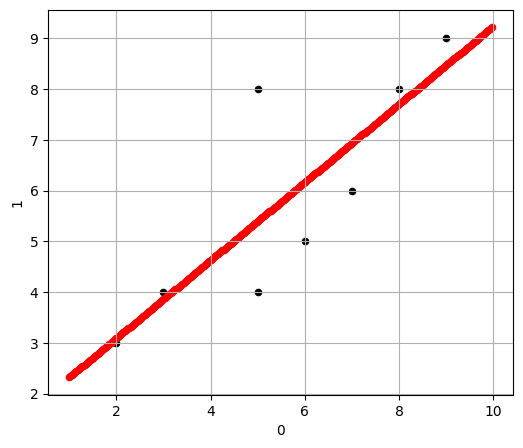

In [3]:
df2 = pd.DataFrame([[x, eq(x)] for x in np.arange(1, 10, 0.025)])

ax = df.plot(kind="scatter", x=0, y=1, figsize=(6, 5), color="k")
df2.plot(kind="scatter", x=0, y=1, color="r", grid=2, ax=ax);

#### 1.2. Soma dos Erros ao Quadrado

Para uma regressão simples de duas variáveis usamos uma fórmula de bolso, entretanto para regressão múltipla usamos a minimização da soma dos erros ao quadrado como função para tentar buscar a melhor reta.

Tudo começa com um chute inicial, digamos beta0 sendo 2 e beta1 sendo 1.

In [4]:
# Chute Inicial
beta0, beta1 = 2, 1
eq = lambda x: beta1 * x + beta0

df["yhat"] = df[0].apply(lambda x: eq(x))

# Soma dos erros ao quadrado
e = np.sum((df[0] - df["yhat"]) ** 2)

print(f"O erro do chute foi: {e}")

O erro do chute foi: 32


O Erro do chute foi 32, agora precisamos de uma fórma inteligente de tentar buscar novos valores de beta0 e novos valores de beta1.

Não podemos percorrer infinitos valores, pois pode ser computacionalmente impossível ou bastante trabalhoso percorrer várias iterações em vários valores de beta0 e beta1 a fim de encontrar qual combinação me garande a menor soma dos erros ao quadrado.

In [6]:
# Lista de possíveis valores para os coeficientes
coefs = np.arange(-3, 3, 0.01)

# Irei gerar 360.000 treinamentos com vários valores de beta1 e beta0
# e encontrar qual é o que da o menor erro possível.
len(coefs) * len(coefs)

360000

Por exemplo, são 360.000 treinamentos para percorrer valores de beta de -3 até 3 pulando de 0.01 em 0.01 para os coeficientes beta0 e beta1.

In [7]:
list_erros = []

for beta0 in coefs:
    for beta1 in coefs:
        eq = lambda x: beta1 * x + beta0
        df["yhat"] = df[0].apply(lambda x: eq(x))

        e = np.sum((df[0] - df["yhat"]) ** 2)

        list_erros.append({"beta0": beta0, "beta1": beta1, "e": e})

dfe = pd.DataFrame(list_erros)

Fazendo essa iteração 360000 vezes, o melhor beta0 e beta1 estão descritos na tabela abaixo:

In [10]:
dfe.sort_values(by="e").head()

,beta0,beta1,e
180400,-6.394885e-14,1.0,2.653602e-24
181000,1.000000e-02,1.0,8.000000e-04
179800,-1.000000e-02,1.0,8.000000e-04
181600,2.000000e-02,1.0,3.200000e-03
179200,-2.000000e-02,1.0,3.200000e-03


In [19]:
beta0, beta1 = dfe.sort_values(by="e").head(1).iloc[:, :-1].values[0].tolist()

eq = lambda x: beta1 * x + beta0
df["yhat"] = df[0].apply(lambda x: eq(x))

e = np.sum((df[0] - df["yhat"]) ** 2)

e

2.6536018674186484e-24

Assim conseguimos obter os melhores parâmetros vizando a minimização dos erros ao quadrado.

o beta0 bem proximo de 0 e o beta1 sendo 1.

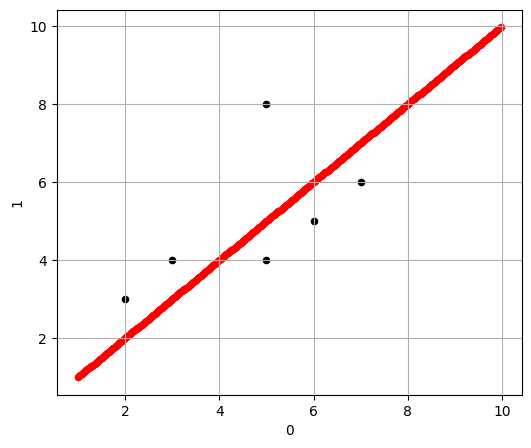

In [21]:
df2 = pd.DataFrame([[x, eq(x)] for x in np.arange(1, 10, 0.025)])

ax = df.plot(kind="scatter", x=0, y=1, figsize=(6, 5), color="k")
df2.plot(kind="scatter", x=0, y=1, color="r", grid=2, ax=ax);

Fixando o melhor beta1, podemos analizar como é o comportamento do beta0 em relação ao erro.

<Axes: xlabel='beta0', ylabel='e'>

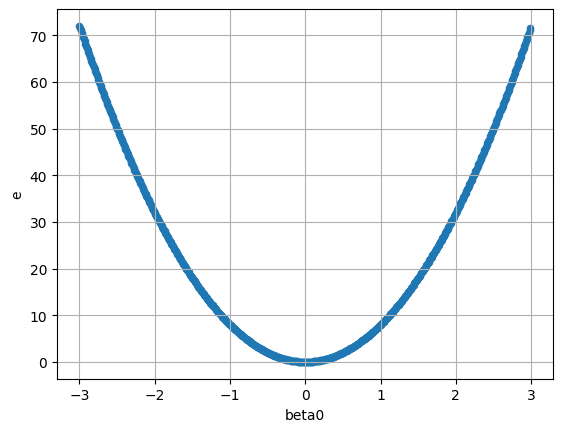

In [83]:
dfe[dfe["beta1"] == beta1].plot(kind="scatter", x="beta0", y="e", grid=2)

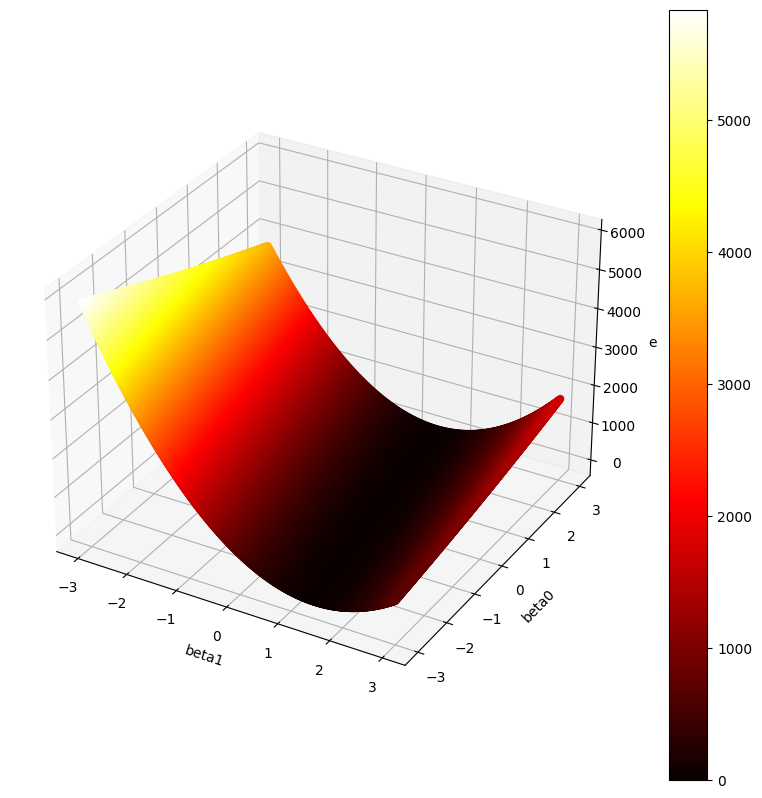

In [63]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
s = ax.scatter(dfe["beta1"], dfe["beta0"], dfe["e"], c=dfe["e"], cmap=plt.get_cmap("hot"));
fig.colorbar(s)
ax.set_xlabel("beta1")
ax.set_ylabel("beta0")
ax.set_zlabel("e");

Agora, o objetivo é, **sabemos como encontrar os melhores coeficientes com a soma dos erros ao quadrado, ou com outra função de erro**, entretanto precisamos **parar quando conseguirmos minimizar e obter um valor razoavel para o erro**, ou seja, quando o erro estiver bem pequeno e não mudar conforme mudamos os parâmetros, então precisamos parar, isso que o algorítimo do gradiente (SGD) ou outro algoritimo de maximização ou minimização ira fazer, por exemplo, no TPE, iremos percorrer quantas "trials" quisermos percorrer a fim de encontrar os melhores $a$ e $l0$ nos exercicios de simple exponential smoothing. Já para a rede neural, podemos percorrer infinitas epocas e sempre caminhar a melhor também se nós utilizarmos o TPE, mas, existem outros otimizadores como o gradiente que é amplamente utilizado.

Em resumo, o gradiente ira observar a imagem acima e quando estiver bem proximo das regiões mais escuras, onde o erro não varia muito, ele ira "parar", as variações da "derivada" não são tão importantes assim. Por exemplo, dos 360.000 fits, apenas 1751 tiveram erros bem baixos.

Não irei detalhar o algorítimo de gradiente pois envolve derivadas e retas tangentes ao mínimo, por exemplo, a reta tangente do gráfico da parábola da imagem acima, fixando o beta1 e variando o beta0, a reta tangente é 0, então é um pouco trabalhoso escrever manualmente as fomulas, então deixa para uma outro oportunidade.

Mas, em resumo, os algoritimos irão calcular essas derivadas e obter os melhores coeficientes, é isso que a rede neural irá fazer.

In [75]:
dfe[dfe.e < 1.0]

,beta0,beta1,e,b
123414,-0.95,1.14,0.9928,0.19
123415,-0.95,1.15,0.9875,0.20
124014,-0.94,1.14,0.9676,0.20
124015,-0.94,1.15,0.9713,0.21
124613,-0.93,1.13,0.9899,0.20
...,...,...,...,...
236187,0.93,0.87,0.9899,1.80
236785,0.94,0.85,0.9713,1.79
236786,0.94,0.86,0.9676,1.80
237385,0.95,0.85,0.9875,1.80


#### 1.3. Neural Net Regression

Agora, vamos criar um deep net bem simples onde queremos obter similarmente o mesmo resultado para as previsões.

Primeiro de tudo, precisamos tratar os dados antes e criar um vetor de vetores para alimentar a rede.

In [3]:
X = df[0].to_numpy().reshape(-1, 1)
Y = df[1].to_numpy().reshape(-1, 1)

X

array([[2],
       [3],
       [6],
       [5],
       [5],
       [7],
       [9],
       [8]])

Depois disso, contruir o modelo.

In [5]:
# Optimizer SGD: https://keras.io/api/optimizers/sgd/
# Linear Activation Function: https://keras.io/api/layers/activations/#linear-function

def build_model():

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(
            1,                                    # Camada de saida
            input_shape=[1],
            activation='linear',                  # Função de ativação da saida (para regressão é a linear)
            kernel_initializer='random_normal',   # Parametro W iniciado com valores de uma Normal Padrão
            bias_initializer='zeros'              # Parametro B inciiados com 0
        )
    ])

    model.compile(
        loss="mse",              # Função de Perda (Loss Function) é o Mean Square Error
        optimizer="sgd",         # Otimizador é o SGD
        metrics=["mae", "mse"]   # Metricas de acompanhamento é o MAE e o MSE
    )

    return model

model = build_model()

Temos 2 parametros para otimizar, esses dois parametros não são os pesos nem bias e sim a quantidade de camadas de saida multiplicado pela quantidade de camadas de entrada + 1.

Isso ajuda a analisar quais camadas você quer treinar levando em conta um fine tuning de modelos mais profundos.

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


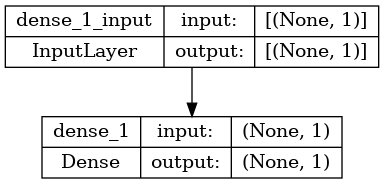

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [7]:
h = model.fit(
    X, Y,
    epochs=10, # 10 épocas de treinamento
    verbose=1
)

Epoch 1/10
1/1 [==============================] - 1s 717ms/step - loss: 32.5062 - mae: 5.3664 - mse: 32.5062
Epoch 2/10
1/1 [==============================] - 0s 4ms/step - loss: 3.6193 - mae: 1.4832 - mse: 3.6193
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 1.8102 - mae: 1.0454 - mse: 1.8102
Epoch 4/10
1/1 [==============================] - 0s 4ms/step - loss: 1.6957 - mae: 0.9962 - mse: 1.6957
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 1.6872 - mae: 0.9837 - mse: 1.6872
Epoch 6/10
1/1 [==============================] - 0s 3ms/step - loss: 1.6853 - mae: 0.9849 - mse: 1.6853
Epoch 7/10
1/1 [==============================] - 0s 3ms/step - loss: 1.6839 - mae: 0.9862 - mse: 1.6839
Epoch 8/10
1/1 [==============================] - 0s 3ms/step - loss: 1.6825 - mae: 0.9858 - mse: 1.6825
Epoch 9/10
1/1 [==============================] - 0s 4ms/step - loss: 1.6811 - mae: 0.9851 - mse: 1.6811
Epoch 10/10
1/1 [==============================] - 

O history armazena todo o histórico das métricas utilizadas.

In [8]:
h.history

{'loss': [32.50623321533203,
  3.619321346282959,
  1.810241460800171,
  1.6956851482391357,
  1.6871780157089233,
  1.6853150129318237,
  1.6838746070861816,
  1.6824675798416138,
  1.6810697317123413,
  1.6796795129776],
 'mae': [5.366410255432129,
  1.4831864833831787,
  1.0454282760620117,
  0.9962215423583984,
  0.9836974143981934,
  0.9849320650100708,
  0.9861530661582947,
  0.9858149290084839,
  0.985088586807251,
  0.9842666387557983],
 'mse': [32.50623321533203,
  3.619321346282959,
  1.810241460800171,
  1.6956851482391357,
  1.6871780157089233,
  1.6853150129318237,
  1.6838746070861816,
  1.6824675798416138,
  1.6810697317123413,
  1.6796795129776]}

In [9]:
model.predict(X)

1/1 [==============================] - 0s 62ms/step


array([[2.1366704],
       [3.1173391],
       [6.0593452],
       [5.078676 ],
       [5.078676 ],
       [7.040014 ],
       [9.001351 ],
       [8.020682 ]], dtype=float32)

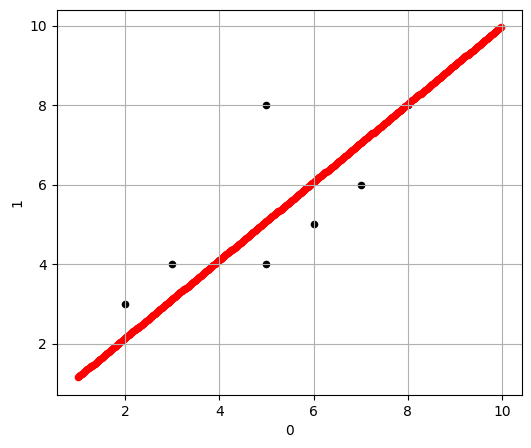

In [34]:
df2 = pd.DataFrame([[x, model.predict(np.array([[x]]), verbose=0)[0][0]] for x in np.arange(1, 10, 0.025)])

ax = df.plot(kind="scatter", x=0, y=1, figsize=(6, 5), color="k")
df2.plot(kind="scatter", x=0, y=1, color="r", grid=2, ax=ax);

In [36]:
df2

,0,1
0,1.000,1.156002
1,1.025,1.180518
2,1.050,1.205035
3,1.075,1.229552
4,1.100,1.254069
...,...,...
355,9.875,9.859436
356,9.900,9.883952
357,9.925,9.908470
358,9.950,9.932986


Para obtermos os coeficientes de cada uma das camadas, no nosso caso só foi uma, usamos o método layers do modelo.

In [22]:
layer = model.layers[0]

print(f"B: {float(layer.bias)}")

for i, w in enumerate(layer.weights):
    print(f"W{i}: {float(w)}")

B: 0.17533308267593384
W0: 0.9806686639785767
W1: 0.17533308267593384


Agora se aplicarmos os passos para a previsão, $z_j = b_j + \sum_{i=1}^1 w_{i,j} x_i$ e $s(z_j)$ obtemos as previsçoes do modelo.

In [44]:
x = 1
b = 0.17533308267593384
w0 = 0.9806686639785767
w1 = 0.17533308267593384

s = tf.keras.activations.linear

# Realizando a previsão de X
z = b + w0 * w1 * 1

print(f"Valor de z: {z}")

# Aplicando a função de ativação Linear
yhat = s(z)

print(f"Valor da Previsão: {yhat}")

Valor de z: 0.3472767426149872
Valor da Previsão: 0.3472767426149872


Linear activation function (pass-through).

A "linear" activation is an identity function: it returns the input, unmodified.

Agora, para desenhar a reta, usamos o mesmo dataset, entretanto aplicando as somas e multiplicações.

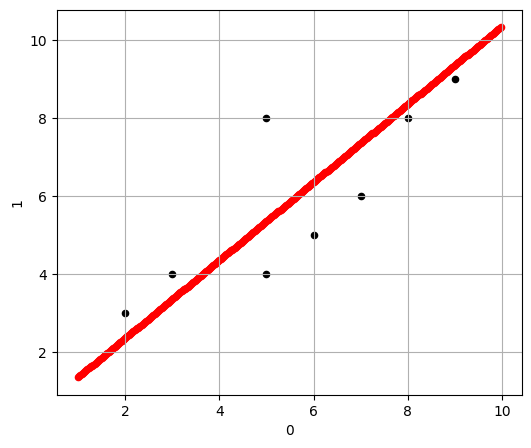

In [45]:
df2 = pd.DataFrame([[x, s(b + w0 * w1 + x)] for x in np.arange(1, 10, 0.025)])

ax = df.plot(kind="scatter", x=0, y=1, figsize=(6, 5), color="k")
df2.plot(kind="scatter", x=0, y=1, color="r", grid=2, ax=ax);

In [46]:
df2

,0,1
0,1.000,1.347277
1,1.025,1.372277
2,1.050,1.397277
3,1.075,1.422277
4,1.100,1.447277
...,...,...
355,9.875,10.222277
356,9.900,10.247277
357,9.925,10.272277
358,9.950,10.297277


#### 1.4. "Deep" Neural Net Regression

Em vez de uma camada agora, irei utilizar duas, na primeira camada vou selecionar a função de ativação "tanh", que varia entre -1 a 1.

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(
            1,
            activation='tanh',
            input_shape=[1],
            kernel_initializer='random_normal',
            bias_initializer='zeros'
        ),
        tf.keras.layers.Dense(
            1,
            activation='linear',
            kernel_initializer='random_normal',
            bias_initializer='zeros'
        )
    ])

    model.compile(
        loss="mse",
        optimizer="sgd",
        metrics=["mae", "mse"]
    )

    return model

model = build_model()

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


Com 500 epocas, o modelo parece que começou a ter overfitting nos poucos dados que temos.

In [12]:
h = model.fit(
    X, Y,
    epochs=500,
    verbose=0
)

In [6]:
Y

array([[3],
       [4],
       [5],
       [4],
       [8],
       [6],
       [9],
       [8]])

In [9]:
model.predict(np.array([[X]]))

1/1 [==============================] - 0s 21ms/step


array([[[[3.3756773],
         [4.6822777],
         [7.1826744],
         [6.6748877],
         [6.6748877],
         [7.463215 ],
         [7.6838894],
         [7.609679 ]]]], dtype=float32)

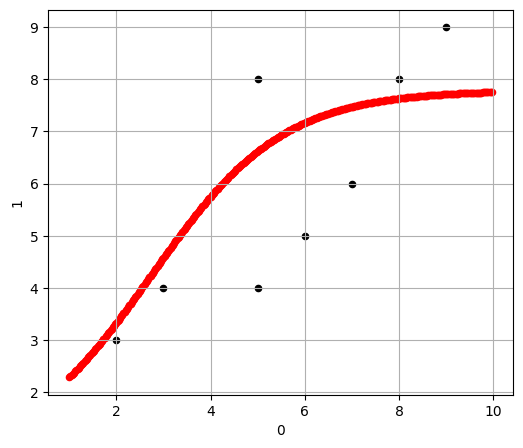

In [13]:
df2 = pd.DataFrame([[x, model.predict(np.array([[x]]), verbose=0)[0][0]] for x in np.arange(1, 10, 0.025)])

ax = df.plot(kind="scatter", x=0, y=1, figsize=(6, 5), color="k")
df2.plot(kind="scatter", x=0, y=1, color="r", grid=2, ax=ax);

### 2.0. US Changes Generic Tensorflow

In [7]:
df = pd.read_csv("../data/us_change.csv", index_col=[0])

df['Quarter'] = df.Quarter.apply(lambda x: x.replace(' ', '-'))
df['Quarter'] = pd.PeriodIndex(df.Quarter, freq='Q').to_timestamp()

df

,Quarter,Consumption,Income,Production,Savings,Unemployment
1,1970-01-01,0.618566,1.044801,-2.452486,5.299014,0.9
2,1970-04-01,0.451984,1.225647,-0.551459,7.789894,0.5
3,1970-07-01,0.872872,1.585154,-0.358652,7.403984,0.5
4,1970-10-01,-0.271848,-0.239545,-2.185691,1.169898,0.7
5,1971-01-01,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...,...
194,2018-04-01,0.983112,0.661825,1.117424,-2.723974,0.0
195,2018-07-01,0.853181,0.806271,1.256722,-0.085686,-0.3
196,2018-10-01,0.356512,0.695142,0.948148,5.031337,0.2
197,2019-01-01,0.282885,1.100753,-0.488206,9.760287,-0.1


#### 2.1. Simple Lin Reg

Irei fazer uma normalização dos dados, subtrair a média e dividir pelo desvio padrão e converter para um vetro de vetores.

In [13]:
dff = df.copy()

dff["Consumption"] = ( dff["Consumption"] - dff["Consumption"].mean() ) / dff["Consumption"].std()
dff["Income"] = ( dff["Income"] - dff["Income"].mean() ) / dff["Income"].std()

In [15]:
X = dff["Consumption"].to_numpy().reshape(-1, 1)
y = dff["Income"].to_numpy().reshape(-1, 1)

In [17]:
X[:5]

array([[-0.19426691],
       [-0.45542389],
       [ 0.20441645],
       [-1.59020035],
       [ 1.81678953]])

##### 2.1.1. One Layer Net

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(
        1,
        input_shape=[1],
        activation='linear',
        kernel_initializer='glorot_uniform', # w
        bias_initializer='zeros'             # b
    )
])

model.compile(
    loss="mse",
    optimizer="sgd",
    metrics=["mae", "mse"]
)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [20]:
h = model.fit(
    X, y,
    epochs=30,
    verbose=1
)

Epoch 1/30
7/7 [==============================] - 1s 1ms/step - loss: 1.0808 - mae: 0.7020 - mse: 1.0808
Epoch 2/30
7/7 [==============================] - 0s 1ms/step - loss: 1.0343 - mae: 0.6852 - mse: 1.0343
Epoch 3/30
7/7 [==============================] - 0s 1ms/step - loss: 0.9939 - mae: 0.6722 - mse: 0.9939
Epoch 4/30
7/7 [==============================] - 0s 1ms/step - loss: 0.9560 - mae: 0.6596 - mse: 0.9560
Epoch 5/30
7/7 [==============================] - 0s 2ms/step - loss: 0.9295 - mae: 0.6508 - mse: 0.9295
Epoch 6/30
7/7 [==============================] - 0s 2ms/step - loss: 0.9103 - mae: 0.6434 - mse: 0.9103
Epoch 7/30
7/7 [==============================] - 0s 2ms/step - loss: 0.8947 - mae: 0.6380 - mse: 0.8947
Epoch 8/30
7/7 [==============================] - 0s 1ms/step - loss: 0.8863 - mae: 0.6342 - mse: 0.8863
Epoch 9/30
7/7 [==============================] - 0s 1ms/step - loss: 0.8779 - mae: 0.6311 - mse: 0.8779
Epoch 10/30
7/7 [==============================] - 0s 1

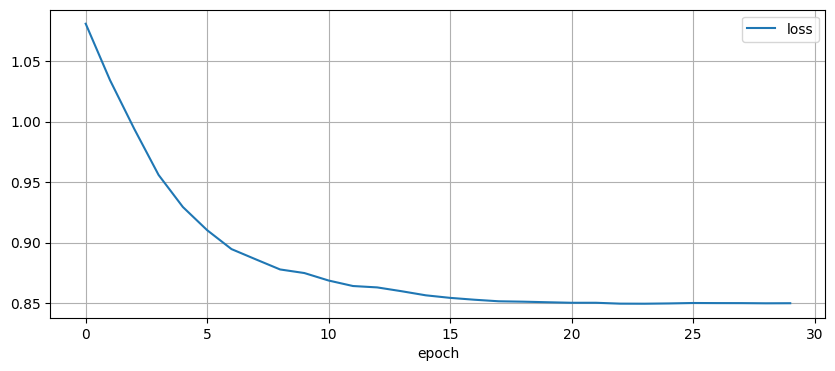

In [21]:
history = pd.DataFrame(h.history | {"epoch": h.epoch})
history.plot(
    x="epoch",
    y="loss",
    grid=2,
    figsize=(10,4)
);

In [22]:
history.tail(5)

,loss,mae,mse,epoch
25,0.850224,0.620323,0.850224,25
26,0.850147,0.620520,0.850147,26
27,0.850121,0.620460,0.850121,27
28,0.849971,0.620212,0.849971,28
29,0.850044,0.620701,0.850044,29


7/7 [==============================] - 0s 993us/step


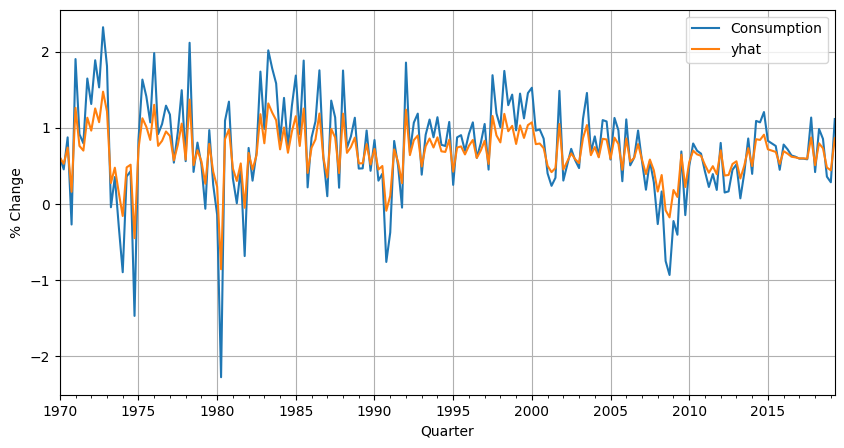

In [23]:
yhat = model.predict(X)

df["yhat"] = yhat
df["yhat"] = ( df["yhat"] + df["Income"].mean() ) * df["Income"].std()

df.plot(
    kind='line', 
    x='Quarter', 
    y=['Consumption', 'yhat'],
    figsize=(10,5),
    ylabel='% Change',
    grid=True
);

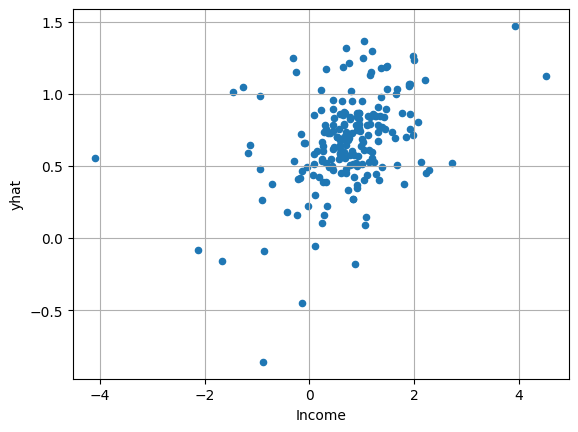

In [24]:
df.plot(
    x="Income",
    y="yhat",
    kind="scatter",
    grid=2
);

In [27]:
model.variables

[<tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.35939717]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.01907374], dtype=float32)>]

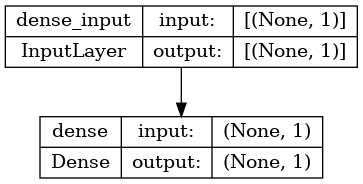

In [28]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

#### 2.2. Multiple Lin Reg

In [3]:
dff = df.copy()

dff["Consumption"] = ( dff["Consumption"] - dff["Consumption"].mean() ) / dff["Consumption"].std()
dff["Savings"] = ( dff["Savings"] - dff["Savings"].mean() ) / dff["Savings"].std()
dff["Income"] = ( dff["Income"] - dff["Income"].mean() ) / dff["Income"].std()

In [4]:
X = dff[["Savings", "Consumption"]].to_numpy()
y = dff["Income"].to_numpy().reshape(-1, 1)

In [5]:
X[:5], y[:5]

(array([[ 0.32647921, -0.19426691],
        [ 0.53463668, -0.45542389],
        [ 0.50238703,  0.20441645],
        [-0.01858213, -1.59020035],
        [ 0.17912008,  1.81678953]]),
 array([[ 0.35166064],
        [ 0.55251287],
        [ 0.95179054],
        [-1.07476849],
        [ 1.38579135]]))

##### 2.2.1. One Layer Net

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(
            1,
            input_shape=[2],
            activation='linear',
            kernel_initializer='glorot_uniform',
            bias_initializer='zeros'
        )
    ])

    model.compile(
        loss="mse",
        optimizer="sgd",
        metrics=["mae", "mse"]
    )

    return model

model = build_model()

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [8]:
h = model.fit(
    X, y,
    epochs=10,
    verbose=1
)

Epoch 1/10


7/7 [==============================] - 1s 2ms/step - loss: 1.5599 - mae: 0.8841 - mse: 1.5599
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 1.1557 - mae: 0.7578 - mse: 1.1557
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.8371 - mae: 0.6465 - mse: 0.8371
Epoch 4/10
7/7 [==============================] - 0s 1ms/step - loss: 0.6148 - mae: 0.5467 - mse: 0.6148
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.4553 - mae: 0.4633 - mse: 0.4553
Epoch 6/10
7/7 [==============================] - 0s 1ms/step - loss: 0.3693 - mae: 0.4144 - mse: 0.3693
Epoch 7/10
7/7 [==============================] - 0s 1ms/step - loss: 0.2977 - mae: 0.3708 - mse: 0.2977
Epoch 8/10
7/7 [==============================] - 0s 1ms/step - loss: 0.2520 - mae: 0.3394 - mse: 0.2520
Epoch 9/10
7/7 [==============================] - 0s 1ms/step - loss: 0.2116 - mae: 0.3076 - mse: 0.2116
Epoch 10/10
7/7 [==============================] - 0s 1ms/step - l

,loss,mae,mse,epoch
5,0.369342,0.414371,0.369342,5
6,0.297704,0.370755,0.297704,6
7,0.252031,0.339440,0.252031,7
8,0.211552,0.307647,0.211552,8
9,0.191595,0.290069,0.191595,9


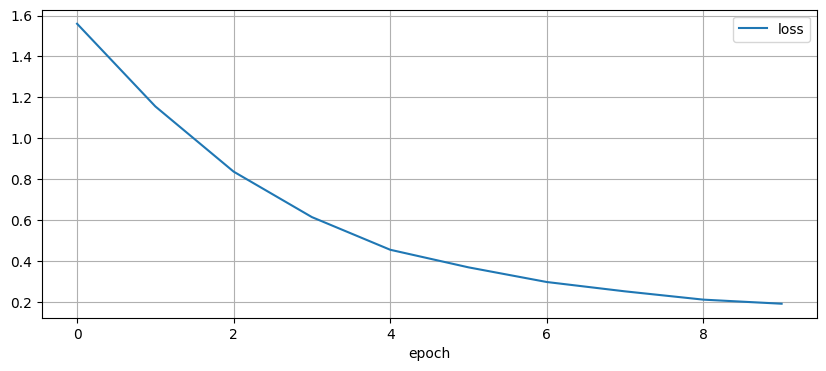

In [9]:
history = pd.DataFrame(h.history | {"epoch": h.epoch})
history.plot(
    x="epoch",
    y="loss",
    grid=2,
    figsize=(10,4)
);

history.tail(5)

7/7 [==============================] - 0s 633us/step


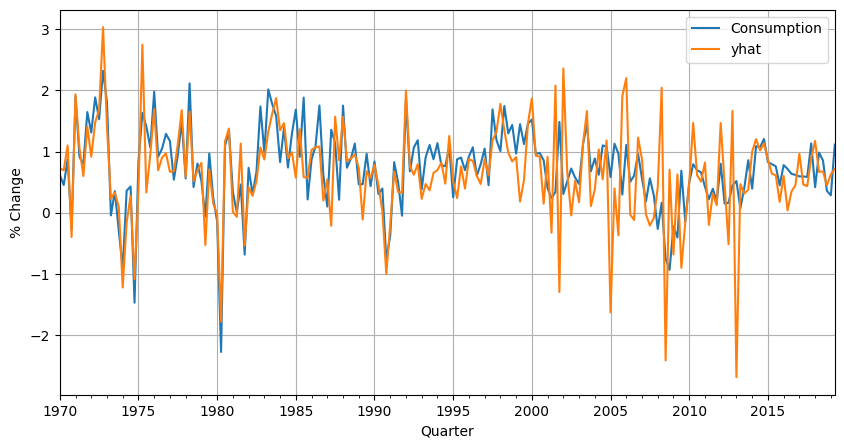

In [11]:
yhat = model.predict(X)

df["yhat"] = yhat
df["yhat"] = ( df["yhat"] + df["Income"].mean() ) * df["Income"].std()

df.plot(
    kind='line', 
    x='Quarter', 
    y=['Consumption', 'yhat'], #'Savings',
    figsize=(10,5),
    ylabel='% Change',
    grid=True
);

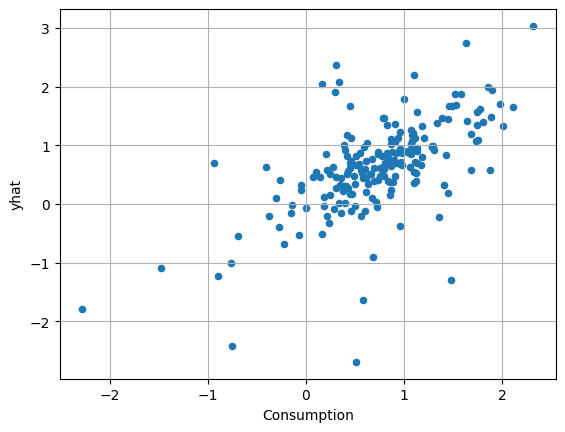

In [13]:
df.plot(
    x="Consumption",
    y="yhat",
    kind="scatter",
    grid=2
);